# Practical session n°5:

##Part I: Quantile Regression with Neural networks.

* Adapted Cost Function
* Two examples with FCN
* A simultaneous quantile regression

##Part II: Sampling with GANs.

* Basic Principle and First Training
* Limitations
* A Wasserstein GAN

Duration: 4 hours

### Partie I: quantile regression   

In this part, we immerse ourselves again in the context where the training inputs ($x$) and targets ($y$) are images of the same spatial dimensions. However, we assume that the dependence of $y$ on $x$ is probabilistic in nature. In other words, there exist conditional laws $p(y | x)$, and these laws need to be characterized.

Here, we limit ourselves to conditional marginals, meaning the laws $p(y_{i,j} | x)$ where $y_{i,j}$ represents the value of the target $y$ at the pixel $(i,j)$. To characterize these laws, several approaches are possible. For instance, one can attempt to estimate their quantiles or moments. The following exercises illustrate a method for estimating quantiles.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms


In [2]:
! git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 399 (delta 122), reused 141 (delta 93), pack-reused 210
Receiving objects: 100% (399/399), 77.81 MiB | 4.89 MiB/s, done.
Resolving deltas: 100% (162/162), done.


**Exercise 1**: an adapted cost function

As seen in the previous practical session n°3, using the Mean Absolute Error (MAE) led the model to provide the conditional median, which is a particular quantile. To estimate other quantiles, it is sufficient to modify the MAE.

This is what we are going to do on a simple problem where the link between the input and the target is defined by:
$$y_{i,j} \sim \mathcal{N}(\mu(x_{i,j}), \sigma(x_{i,j})) $$
where $\mu$ and $\sigma$ are a priori unknown.

The gen_proba function from the utile.py module will allow us to "explore" our dataset, or in other words, to sample the random pair $(x, y)$.

In [4]:
os.chdir('ml-student/TP5')
# from utils_TP5 import gen_proba

from utils_TP5 import *
from utils_TP5_exo3 import *

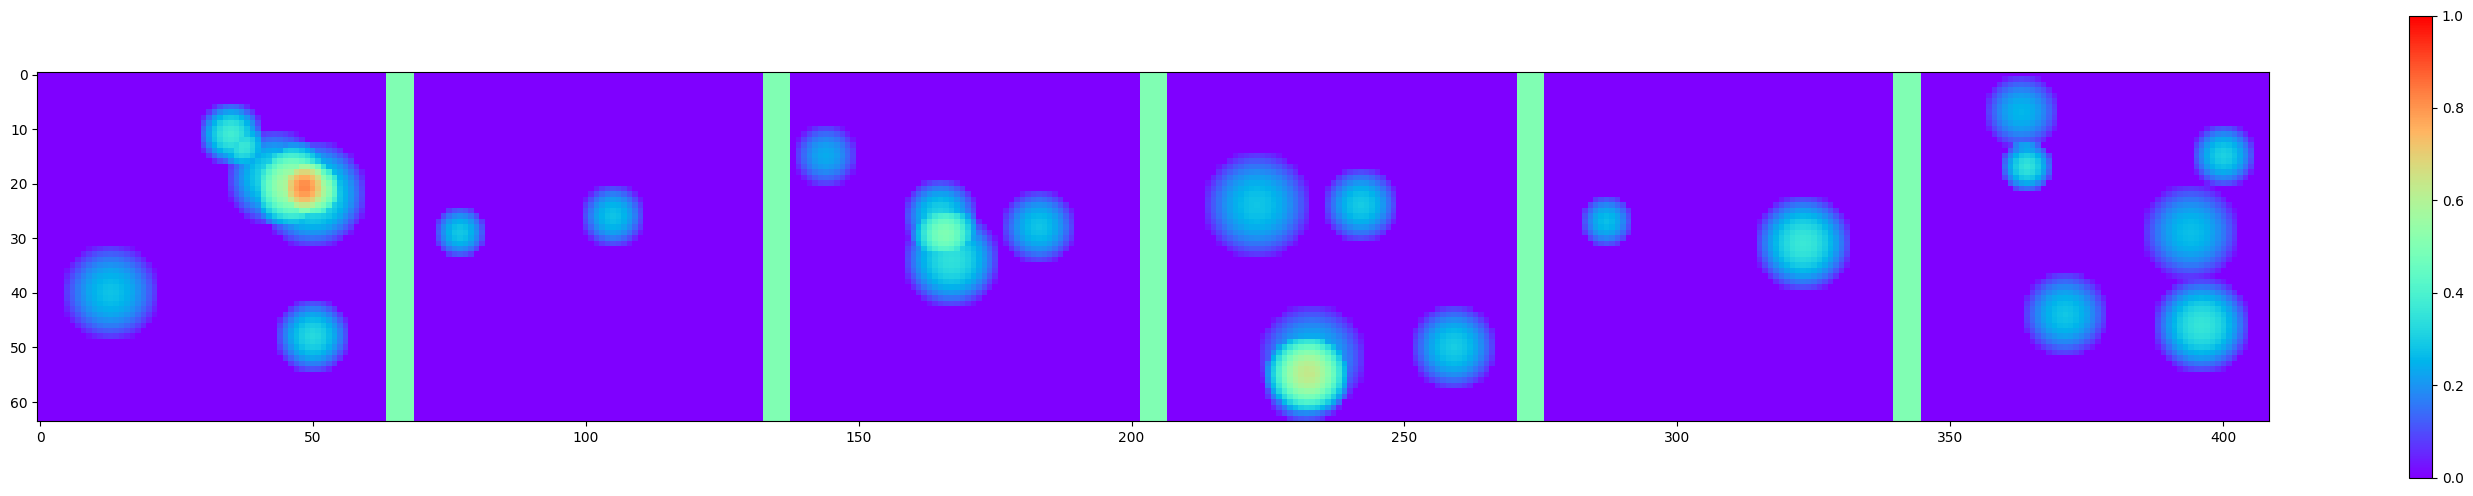

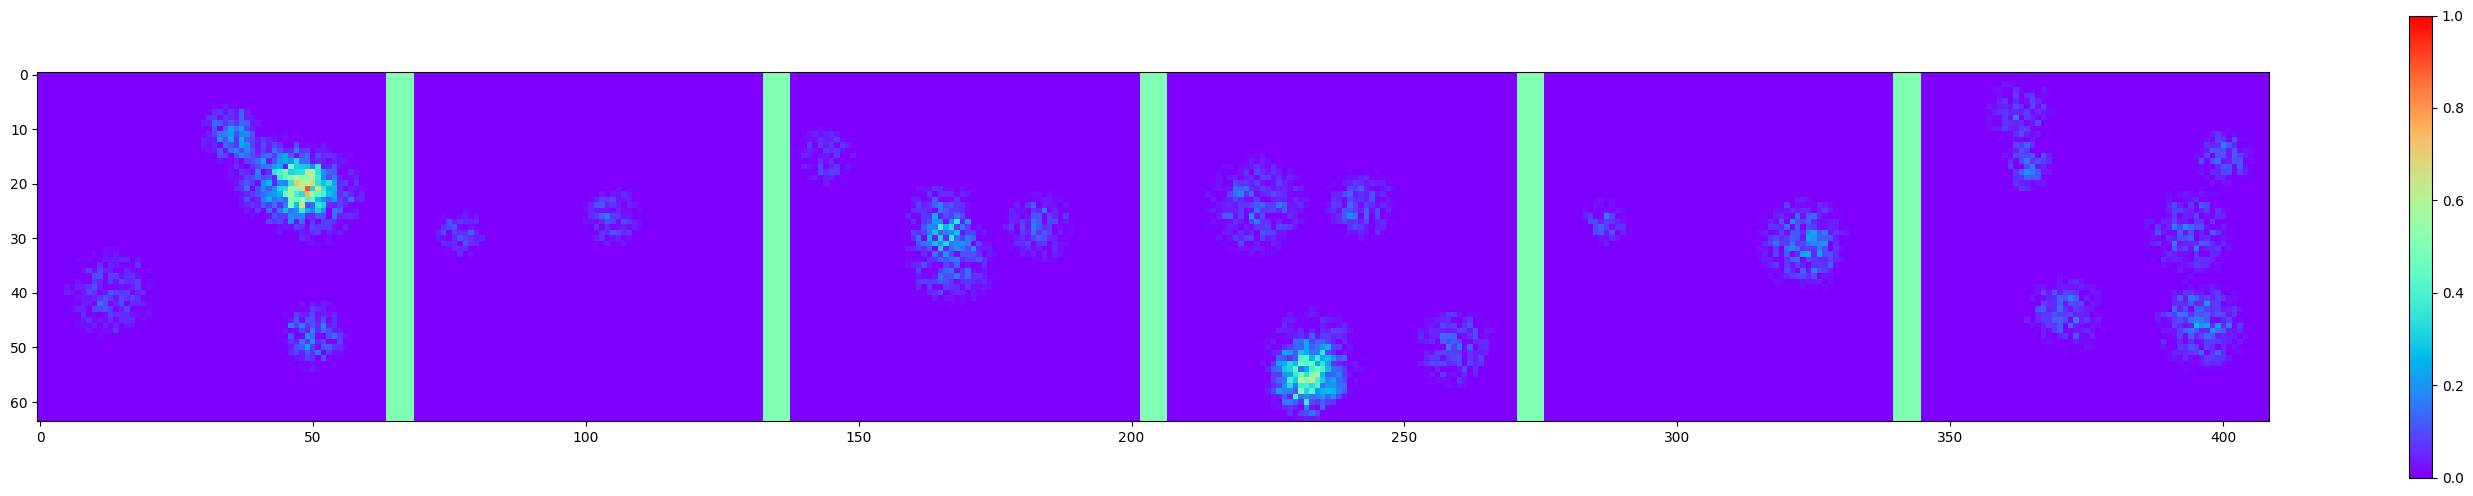

In [5]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Let's consider the cost function be defined at the pixel level by:
$$\mathcal{L}_t(y,z) =  \rho_t(z - y)$$
where:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$

**Q1** Plot the graph of $\rho_t$ for different values of $t$ in the range [0, 1] using *matplotlib.pyplot*.
How does $\mathcal{L}_t$ generalize the MAE?

In [12]:
def rho(t,u):
  return t * max(u, 0) + (t - 1) * min(u, 0)

tps = [0, 0.3, 0.5, 0.7, 1]

u = np.linspace(-4, 4, 100)

def rho0(u):
  return rho(0, u)

plt.plot(u, rho0(u))
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

One can show (see accompanying exercise sheet for the practical session) that the value of $z$ that minimizes the expectation $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , z) ]$ is the $t$-th quantile of the distribution of $y_{i,j}$.

In the context where the value $y_{i,j}$  depends on the image $x$, minimizing $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , f^\theta_{i,j}(x))]$ will therefore constrain the network $f^\theta$ to provide the $t$-th quantile of $p(y_{i,j} | x)$.

**Q2** In the following cell, code a cost function adapted to the estimation of $t$-th quantiles.

In [23]:
t = 0.9

def rho(u,t):
        loss = t * torch.clamp(u, min = 0.) + (t - 1) * torch.clamp(u, max = 0.)
        loss = torch.mean(loss)
        return loss

def criterion(output, target):
  return rho(target-output, t)

**Q3** Train a U-Net to estimate the ninth decile.

In [24]:
fcn = UNet(1, 1, 8)
fcn = fcn.cuda()
epoch = 50
nbatches = 100
batchsize = 64

optimizer = torch.optim.Adam(fcn.parameters(), 0.001)


train_losses = []

for epoch in range(epoch):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_proba(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output,target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.07648928
Epoch 1
epoch loss : 

0.0024797816
Epoch 2
epoch loss : 

0.0017583279
Epoch 3
epoch loss : 

0.0016028422
Epoch 4
epoch loss : 

0.0014730543
Epoch 5
epoch loss : 

0.0014135032
Epoch 6
epoch loss : 

0.0013842466
Epoch 7
epoch loss : 

0.0013805621
Epoch 8
epoch loss : 

0.0013443226
Epoch 9
epoch loss : 

0.001309184
Epoch 10
epoch loss : 

0.0013028888
Epoch 11
epoch loss : 

0.0012967226
Epoch 12
epoch loss : 

0.0016717196
Epoch 13
epoch loss : 

0.0016641086
Epoch 14
epoch loss : 

0.0012896486
Epoch 15
epoch loss : 

0.001291083
Epoch 16
epoch loss : 

0.0012476576
Epoch 17
epoch loss : 

0.001234656
Epoch 18
epoch loss : 

0.0012091191
Epoch 19
epoch loss : 

0.001283462
Epoch 20
epoch loss : 

0.0011972354
Epoch 21
epoch loss : 

0.0012416401
Epoch 22
epoch loss : 

0.0012210627
Epoch 23
epoch loss : 

0.0011908581
Epoch 24
epoch loss : 

0.0011955156
Epoch 25
epoch loss : 

0.0011693239
Epoch 26
epoch loss : 

0.0011777072
Epoch 27
epoch lo

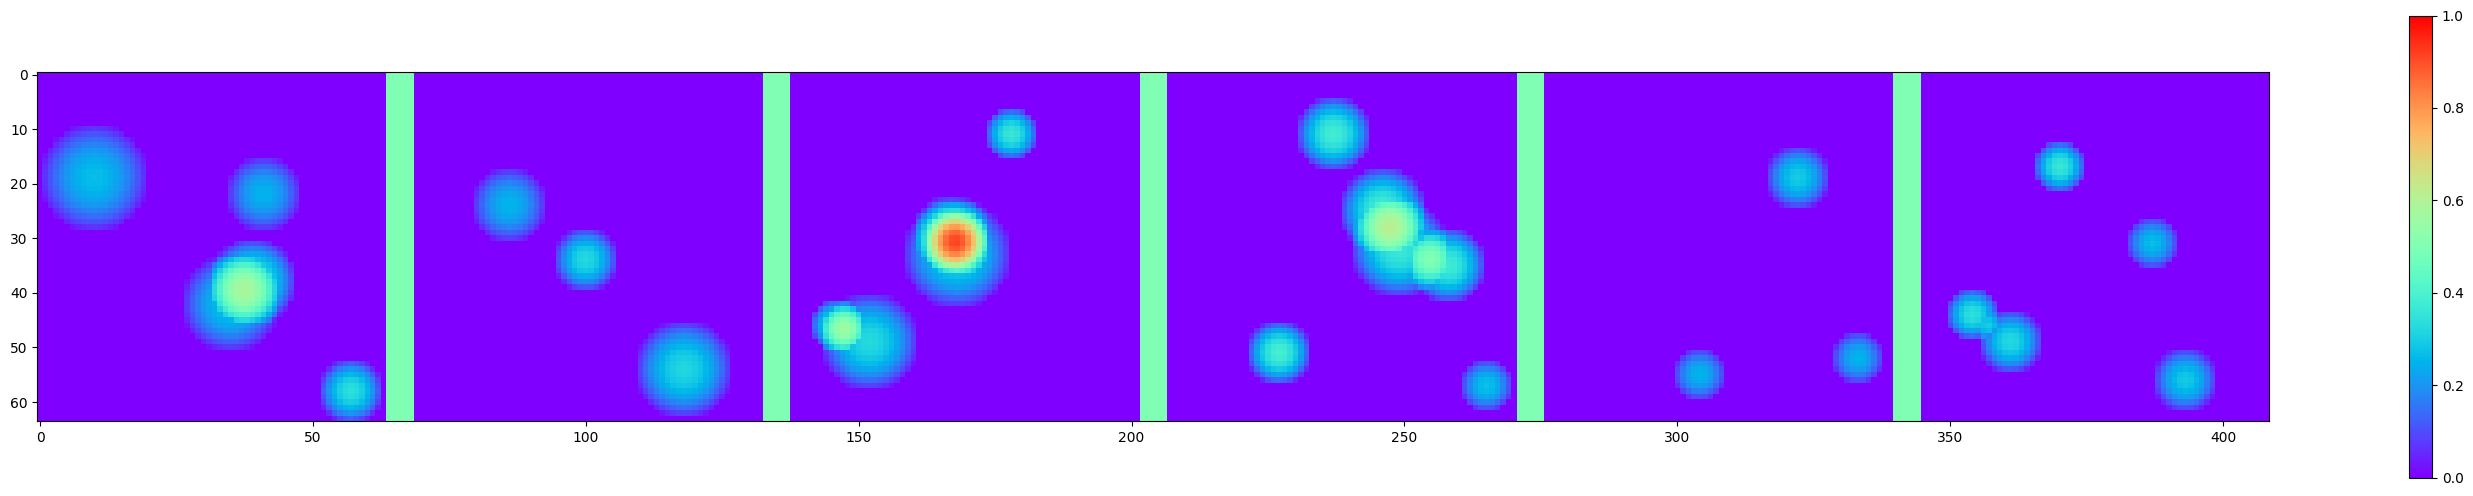

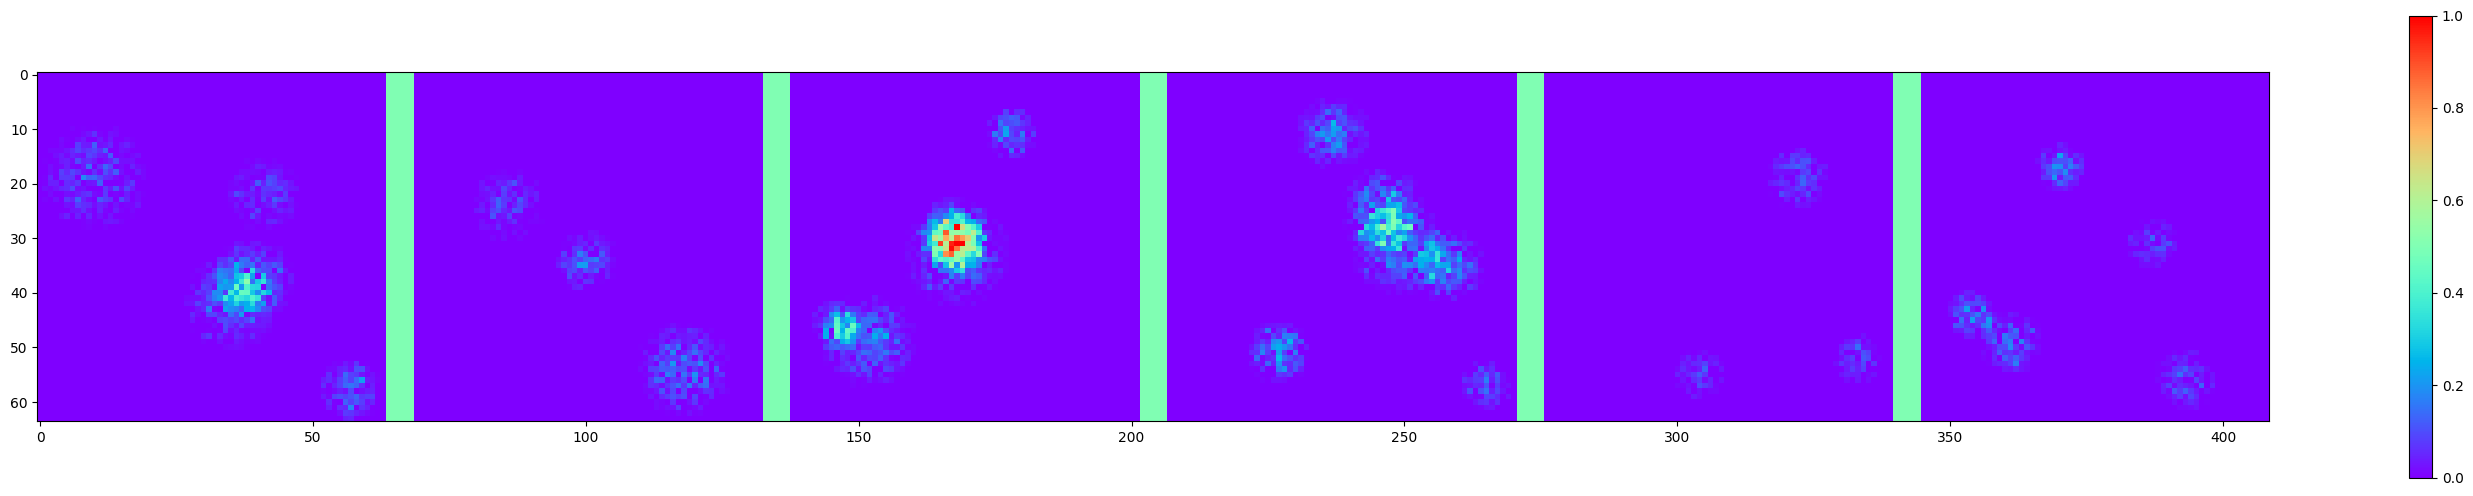

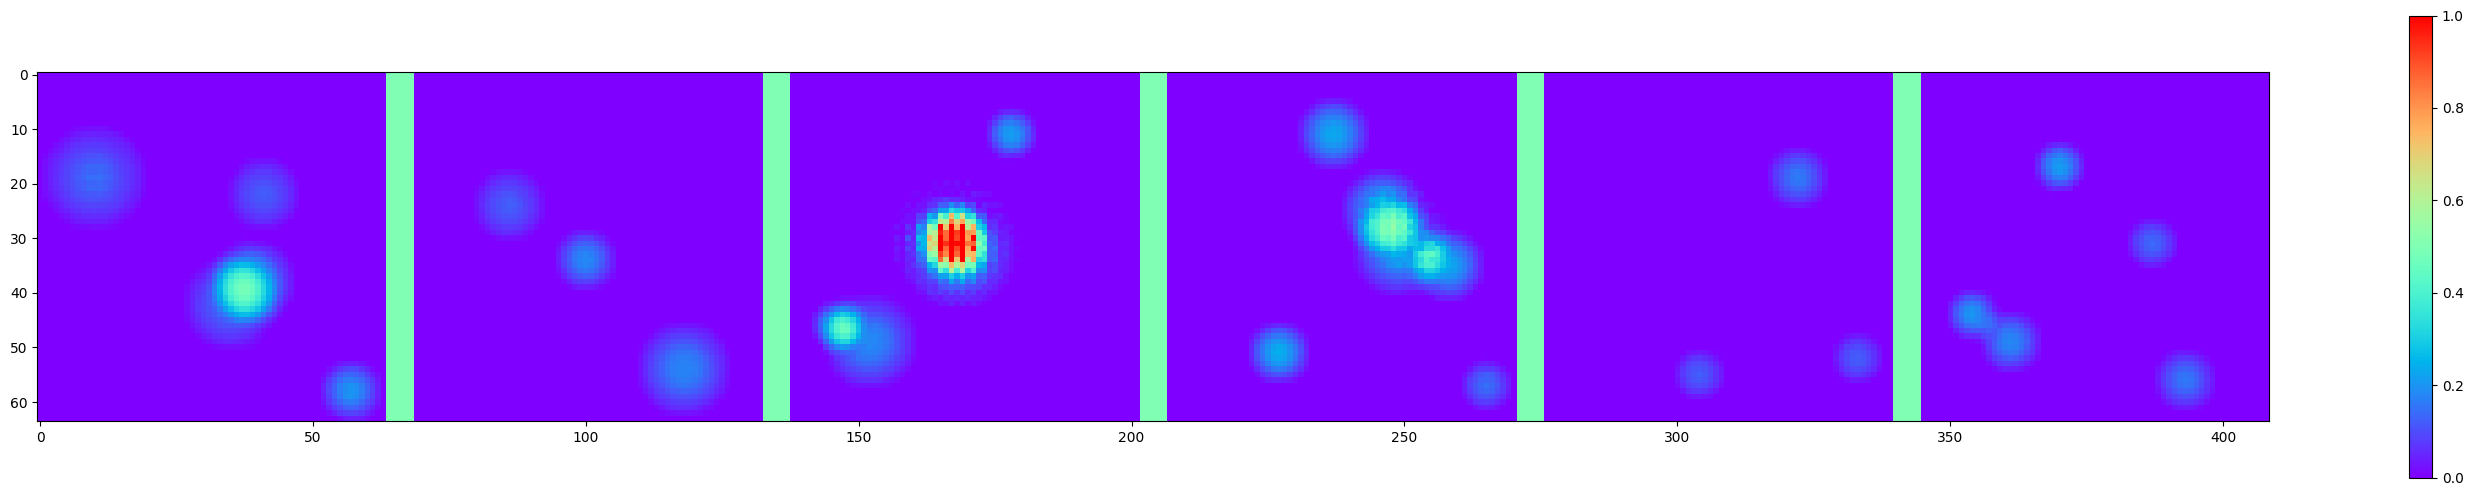

In [25]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

input = input.cuda()

fcn.eval()

output = fcn(input)

output = output.cpu().detach()

fig2 = plt.figure(2, figsize=(36,6))
voir_batch2D(output, 6, fig2, k = 0, min_scale = 0, max_scale = 1)

**Q4** The ground truth is given by:
$$ \mu(x_{i,j}) = {x}_{i,j}^2 $$
and
$$ \sigma(x_{i,j}) = 0.2 \times x_{i,j} $$

Use [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) to verify that the result corresponds well to the expected quantile.

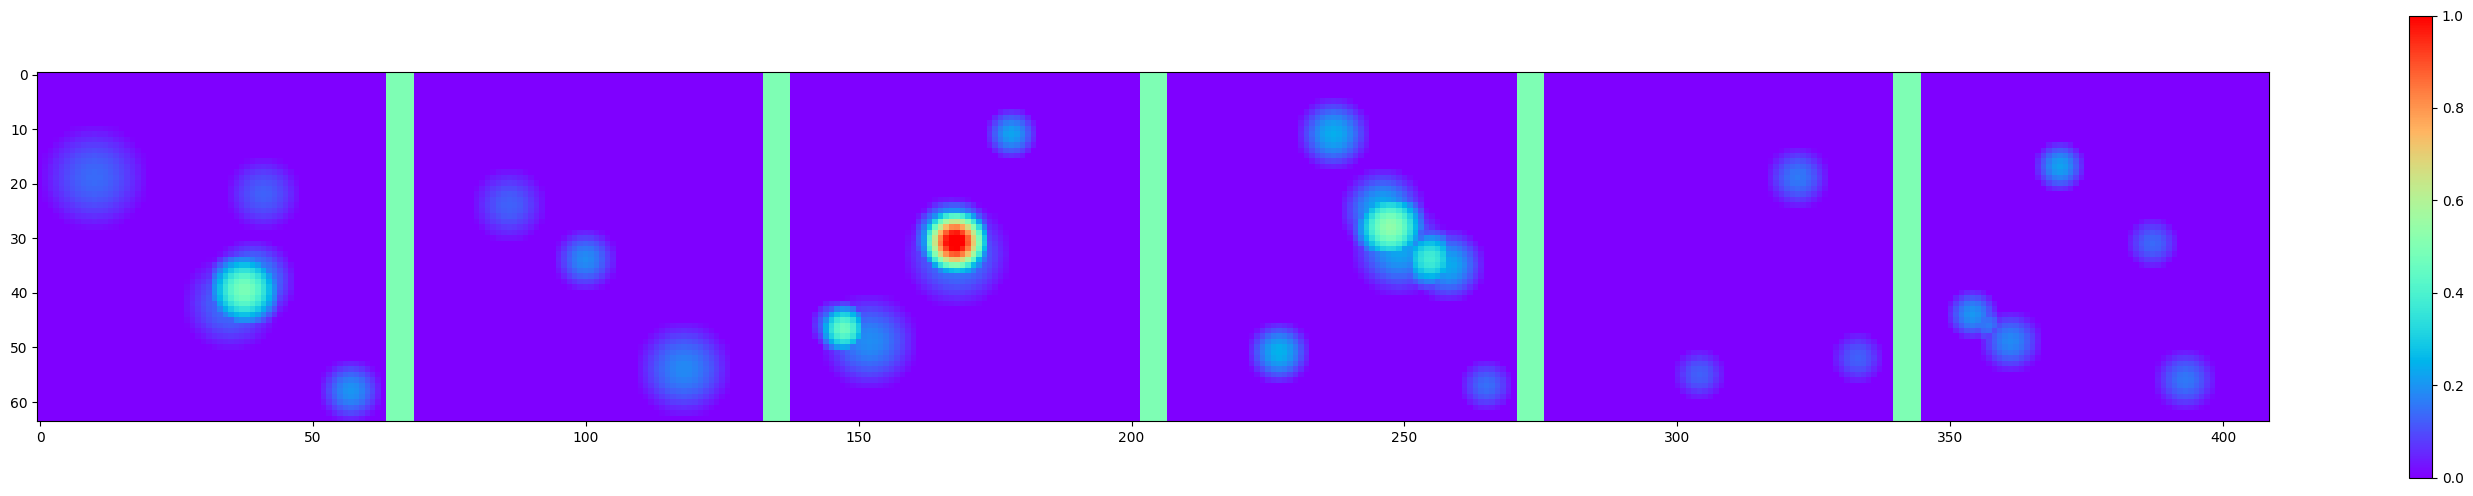

In [29]:
input = input.cpu()
m = torch.distributions.normal.Normal(input**2, 0.2 * input + 0.000001, validate_args = None)
quantile = m.icdf(0 * input + 0.9)
fig3 = plt.figure(3, figsize=(36,6))
voir_batch2D(quantile, 6, fig3, k = 0, min_scale = 0, max_scale = 1)

**Exercise 2**: a trickier dependence

Let's now work with the *gen_proba_2* function. Here, the dependence of $y$ upon $x$ is not clearly visible in the input-target pairs:

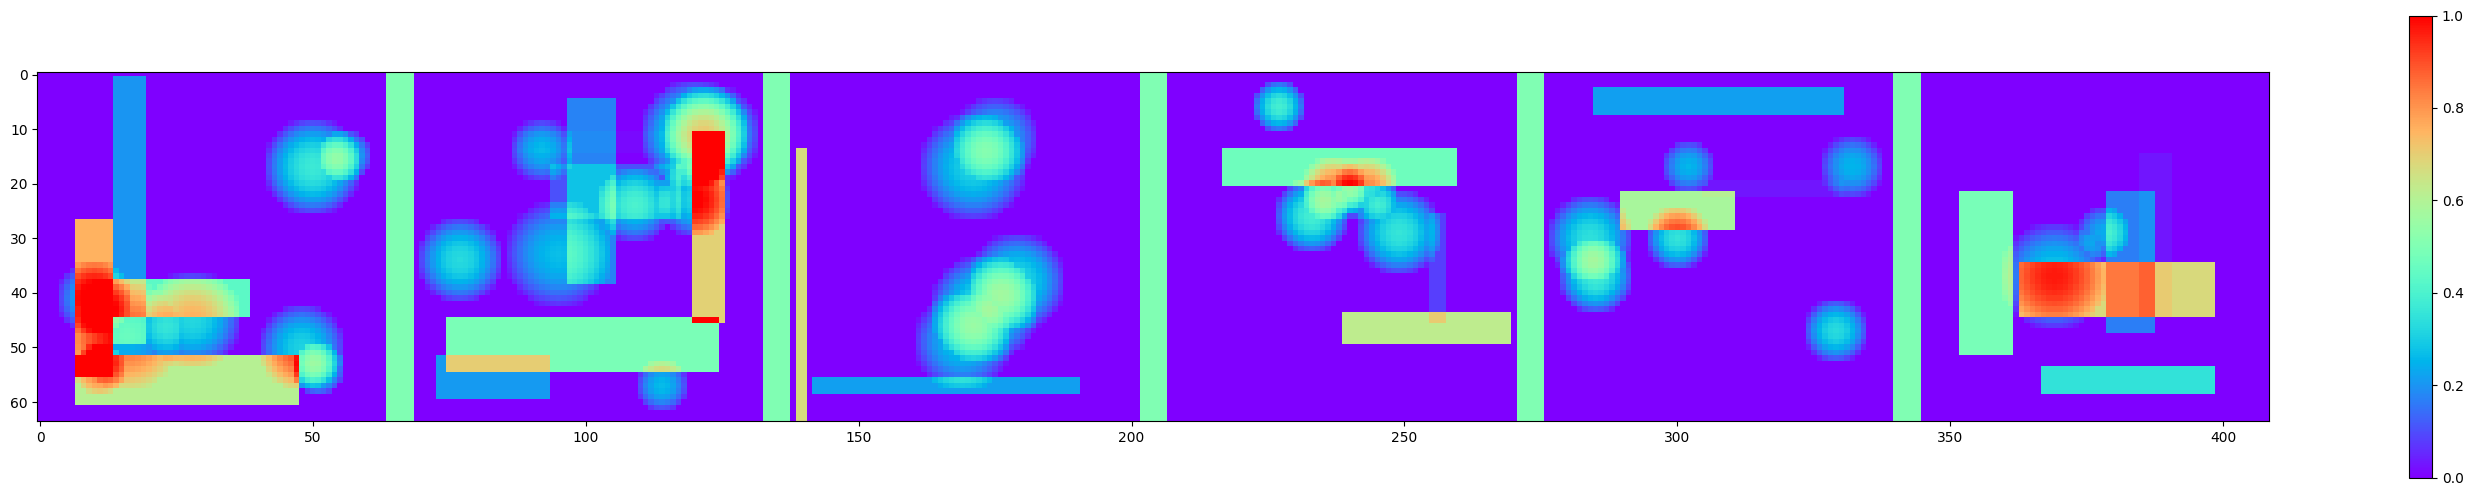

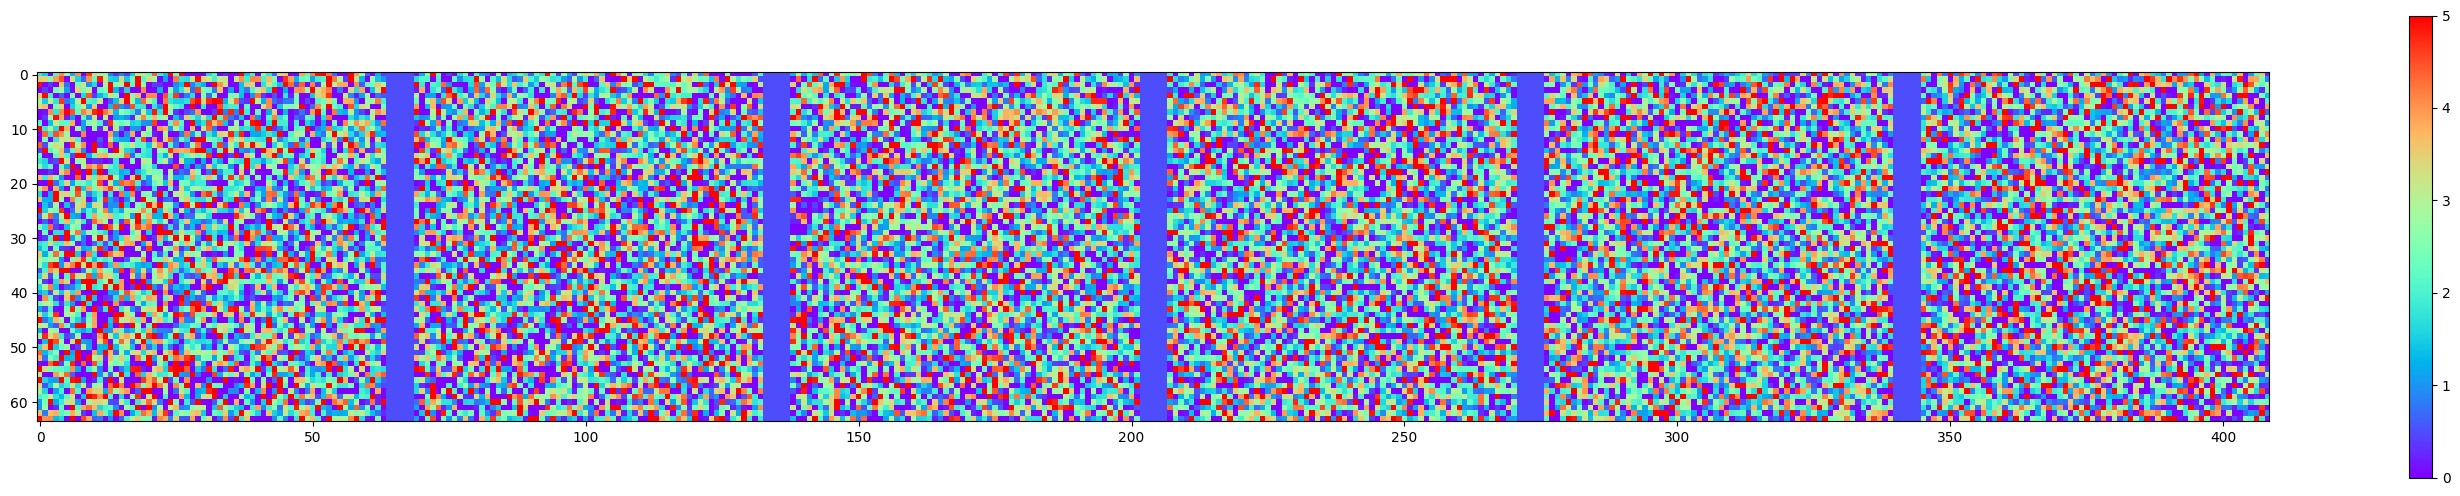

In [ ]:
input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

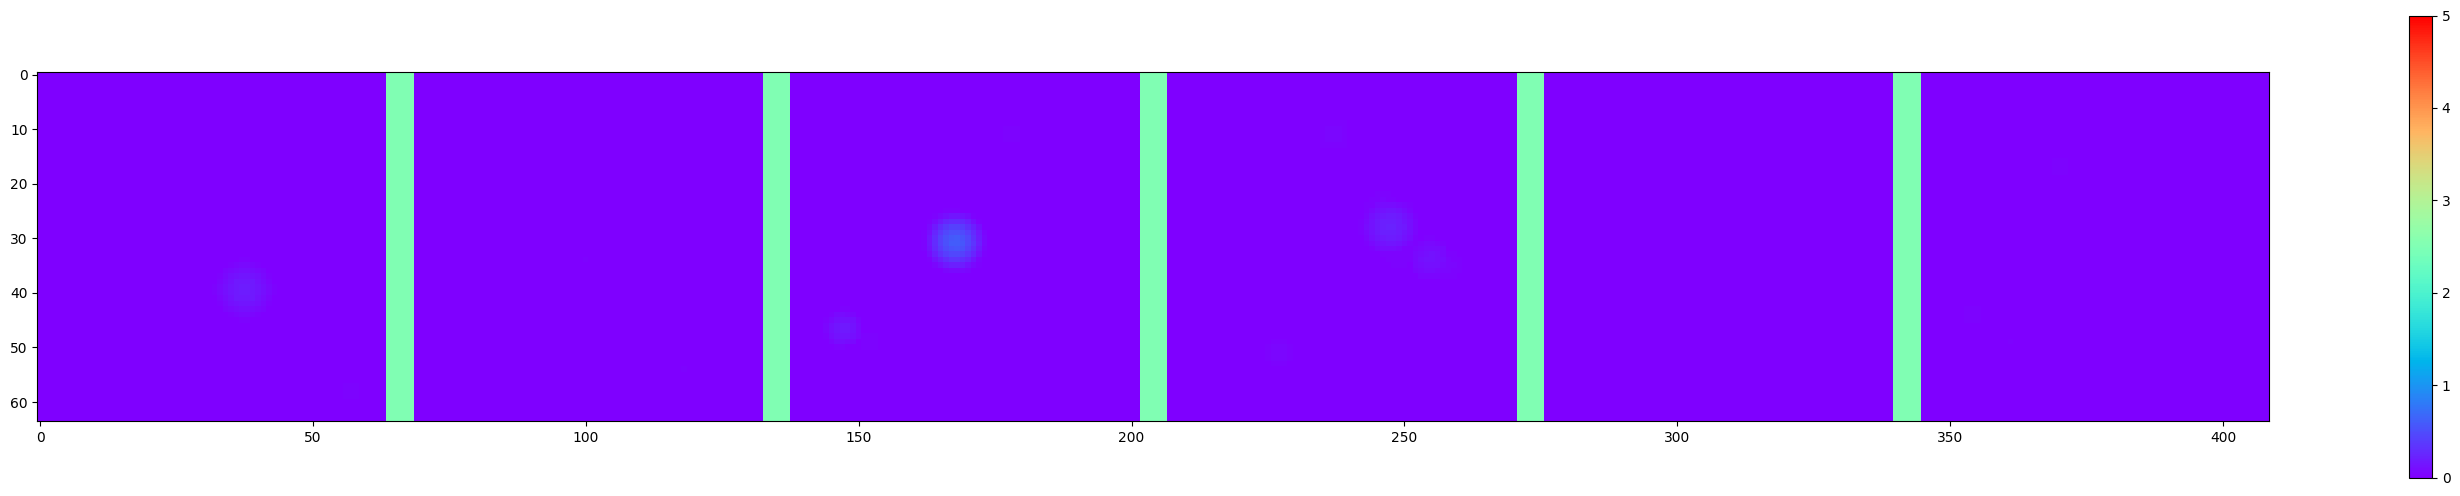

In [30]:
quantile1 = m.icdf(0 * input + 0.1)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(quantile1, 6, fig2, k=0, min_scale=0,max_scale=5)

**Q1** Estimate the 0.1 quantiles of the marginal distributions and visualize the result.

In [31]:
t = 0.1

def rho(u,t):
        loss = t * torch.clamp(u, min = 0.) + (t - 1) * torch.clamp(u, max = 0.)
        loss = torch.mean(loss)
        return loss

def criterion(output, target):
  return rho(target-output, t)

In [34]:
fcn = UNet(1, 1, 8)
fcn = fcn.cuda()
epoch = 50
nbatches = 100
batchsize = 64

optimizer = torch.optim.Adam(fcn.parameters(), 0.001)


train_losses = []

for epoch in range(epoch):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_proba_2(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output,target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.3705981
Epoch 1
epoch loss : 

0.36617768
Epoch 2
epoch loss : 

0.36601222
Epoch 3
epoch loss : 

0.36572444
Epoch 4
epoch loss : 

0.365774
Epoch 5
epoch loss : 

0.36602774
Epoch 6
epoch loss : 

0.36590645
Epoch 7
epoch loss : 

0.36565423
Epoch 8
epoch loss : 

0.36584544
Epoch 9
epoch loss : 

0.36579013
Epoch 10
epoch loss : 

0.36571956
Epoch 11
epoch loss : 

0.36586103
Epoch 12
epoch loss : 

0.36582193
Epoch 13
epoch loss : 

0.36578655
Epoch 14
epoch loss : 

0.36592183
Epoch 15
epoch loss : 

0.36554778
Epoch 16
epoch loss : 

0.36573657
Epoch 17
epoch loss : 

0.36564395
Epoch 18
epoch loss : 

0.36576915
Epoch 19
epoch loss : 

0.3658351
Epoch 20
epoch loss : 

0.36593238
Epoch 21
epoch loss : 

0.36594155
Epoch 22
epoch loss : 

0.36597535
Epoch 23
epoch loss : 

0.3659351
Epoch 24
epoch loss : 

0.36579594
Epoch 25
epoch loss : 

0.365848
Epoch 26
epoch loss : 

0.36604047
Epoch 27
epoch loss : 

0.36571026
Epoch 28
epoch loss : 

0.36606735
Ep

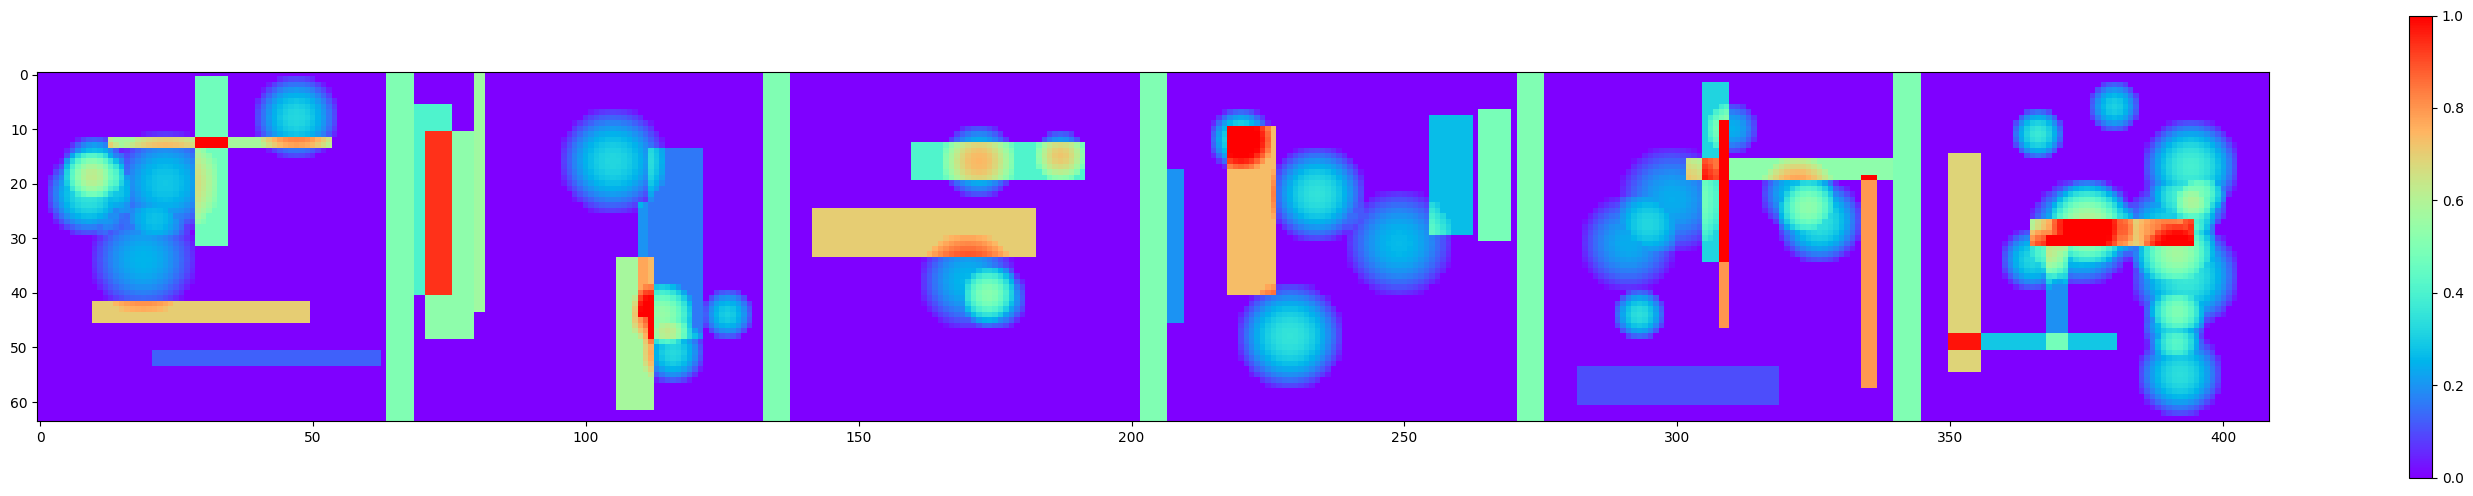

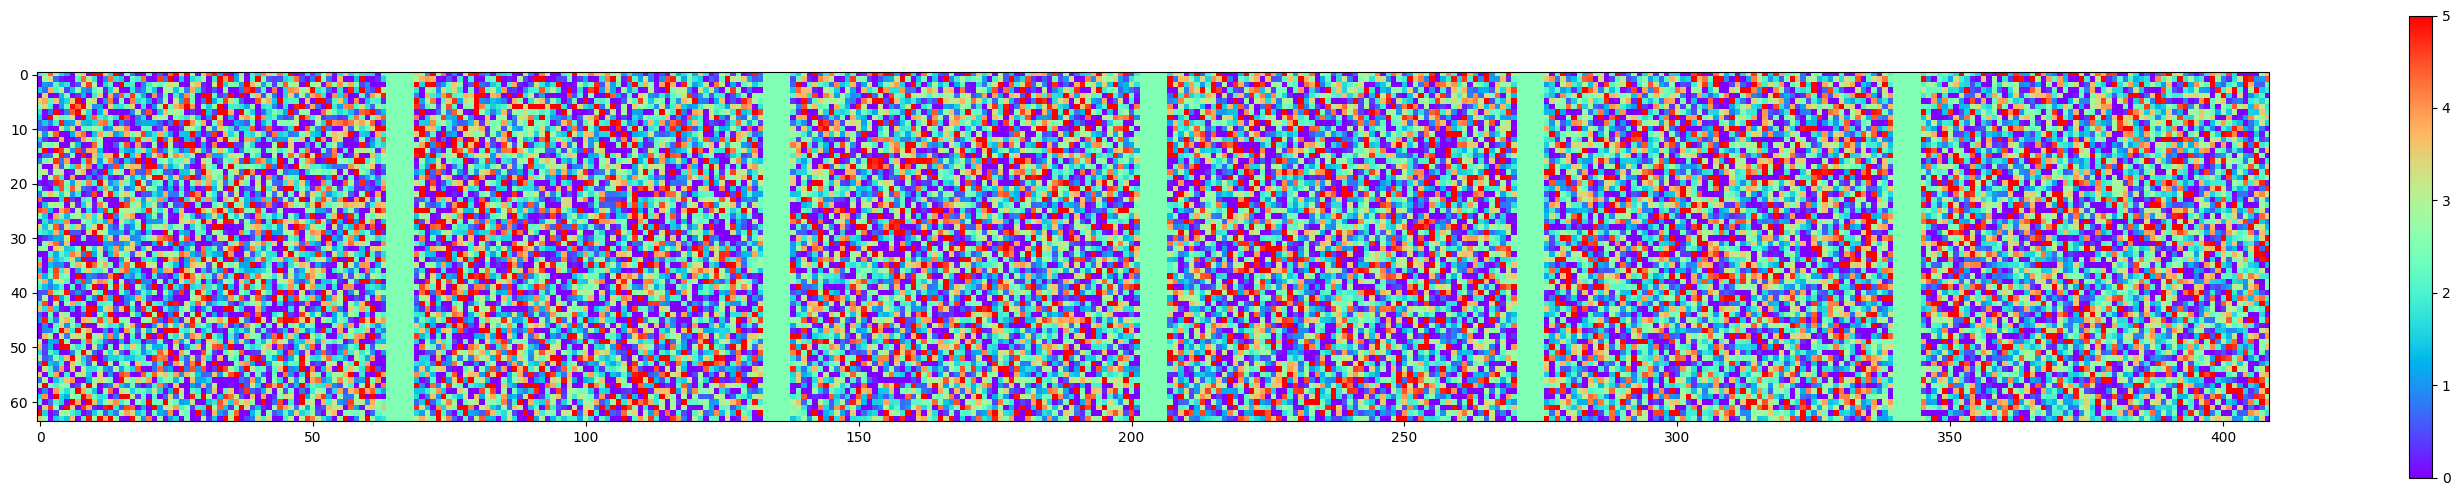

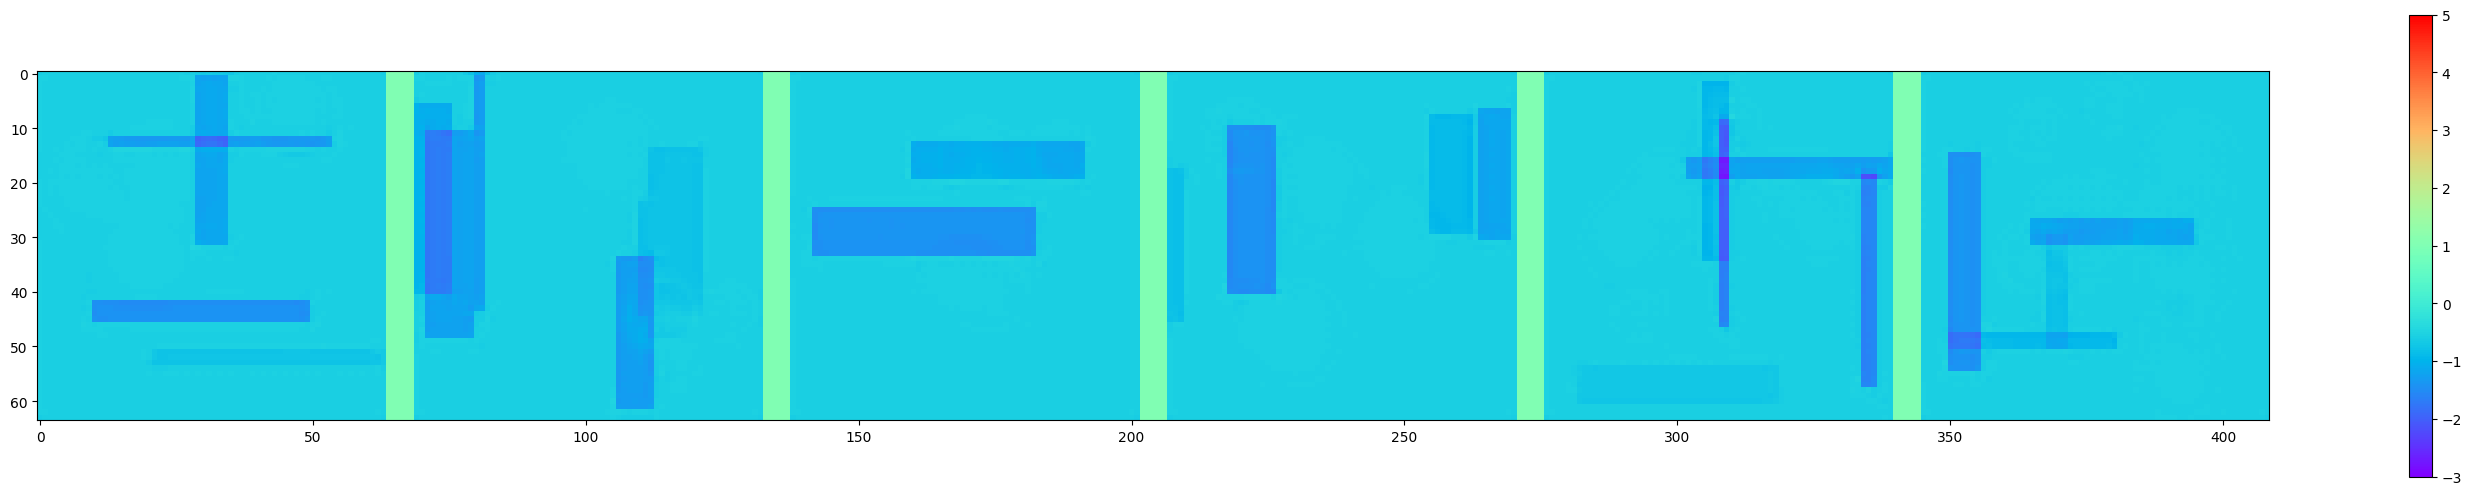

In [38]:
# sampling (x,y) :

input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

input = input.cuda()

fcn.eval()

output = fcn(input)

output = output.cpu().detach()

fig2 = plt.figure(2, figsize=(36,6))
voir_batch2D(output, 6, fig2, k = 0, min_scale = -3, max_scale = 5)

**Q2** Do we have a dependance ? Is it still a pixel-wise dependence (i.e., does the distribution of $y_{i,j}$ depend only on $x_{i,j}$)?

**Exercise 3**:

One can attempt to estimate $n$ quantiles simultaneously. To achieve this, the simplest way is to:

* change the number of output channels of the U-Net—e.g., 99 channels if you are estimating the $n = 100$ quantiles of orders 1%, 2%, ... 99%.
* define the overall cost function by summing individual cost functions for each of the channels.
The goal of this exercise is to code a matrix version of this overall cost function and illustrate the convergence of the learning process.


**Q1** Let $t$ be a vector of size $n-1$, and $M$ be a 4th-order tensor. Code the function: $$dot(t, M) = M^{\prime}$$ where: $$M^{\prime}_{b,i,j} = \underset{0<c<n}{\sum} t_c \times M_{b,c,i,j}$$.

This function will allow to apply $\rho_{t_c}$ (see **Exercise 1**) to each channel $c$ of the output $M$ (where $b$ represents the batch index and $i,j$ represent spatial dimensions).

In [35]:
def dot(t, M):
  M_prime = 0
  c = M.size(dim = 1)
  for i in range(c):
    M_prime += t[i] * M[:, i, :, :]

**Q2** Complete the class *QuantileLoss*:

In [ ]:
class QuantileLoss(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = ...

    def forward(self, output, target):
        bs, _, nx, ny = target.shape
        d = target.view(bs, 1, nx, ny) - output
        loss_by_pix = ...
        loss = ...

        return loss

**Q3** Start the training with *gen_proba* and $n=100$, then evaluate the estimation.